Episode 10/100 - Reward: -120.00, Loss: 8.8721, Epsilon: 0.9511, Test MSE: 0.0000
Episode 20/100 - Reward: -120.00, Loss: 3.5441, Epsilon: 0.9046, Test MSE: 0.0000
Episode 30/100 - Reward: -50.00, Loss: 2.5140, Epsilon: 0.8604, Test MSE: 0.0000
Episode 40/100 - Reward: -100.00, Loss: 1.8248, Epsilon: 0.8183, Test MSE: 0.0000
Episode 50/100 - Reward: -16.10, Loss: 1.4336, Epsilon: 0.7783, Test MSE: 0.0000
Episode 60/100 - Reward: -120.00, Loss: 1.2064, Epsilon: 0.7403, Test MSE: 0.0000
Episode 70/100 - Reward: -120.00, Loss: 2.0630, Epsilon: 0.7041, Test MSE: 0.0000
Episode 80/100 - Reward: -70.00, Loss: 2.5452, Epsilon: 0.6696, Test MSE: 0.0000
Episode 90/100 - Reward: -40.00, Loss: 2.4053, Epsilon: 0.6369, Test MSE: 0.0000
Episode 100/100 - Reward: 0.00, Loss: 2.1494, Epsilon: 0.6058, Test MSE: 0.0000

Final DQN Test MSE: 0.0000


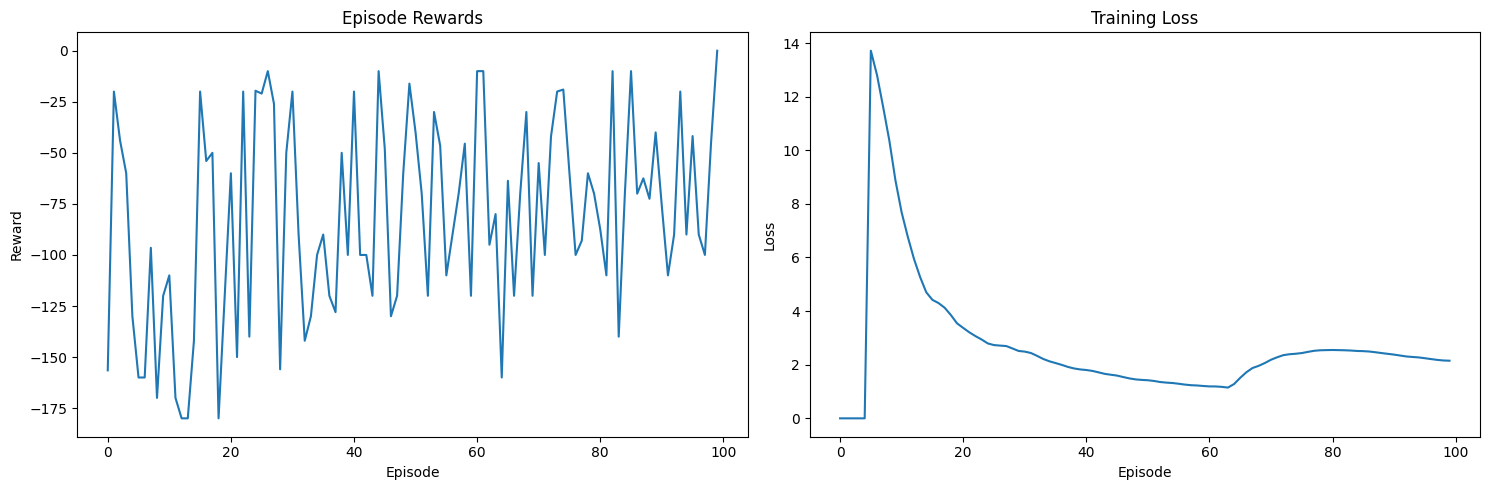

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Load the dataset locally
file_path = 'amazon_delivery.csv'  # Update the path here
delivery_data = pd.read_csv(file_path)

# Drop unnecessary columns
delivery_data = delivery_data.drop(columns=["Order_ID", "Order_Date", "Order_Time", "Pickup_Time"])

# Encode categorical columns
categorical_columns = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
delivery_data = pd.get_dummies(delivery_data, columns=categorical_columns)

# Ensure numeric format
numeric_columns = ["Agent_Age", "Agent_Rating", "Store_Latitude", "Store_Longitude",
                   "Drop_Latitude", "Drop_Longitude", "Delivery_Time"]
delivery_data[numeric_columns] = delivery_data[numeric_columns].apply(pd.to_numeric)

# Calculate distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    d_lat = np.radians(lat2 - lat1)
    d_lon = np.radians(lon2 - lon1)
    a = np.sin(d_lat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(d_lon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

delivery_data["Distance"] = delivery_data.apply(lambda row: haversine(
    row["Store_Latitude"], row["Store_Longitude"],
    row["Drop_Latitude"], row["Drop_Longitude"]
), axis=1)

delivery_data = delivery_data.drop(columns=["Store_Latitude", "Store_Longitude", "Drop_Latitude", "Drop_Longitude"])

# Train-test split
X = delivery_data.drop(columns=['Delivery_Time'])
y = delivery_data['Delivery_Time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Define DQN model
def build_dqn(input_dim, output_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(output_dim, activation='linear')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='mse')  # Reduced learning rate
    return model

# Environment parameters
n_actions = 5
state_dim = X_train.shape[1]
dqn = build_dqn(state_dim, n_actions)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = []
        self.capacity = capacity

    def add(self, state, action, reward, next_state, done):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

buffer = ReplayBuffer()

# DQN parameters
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
episodes = 100
episode_rewards, episode_losses, evaluation_scores = [], [], []
evaluation_interval = 10

# Evaluate function
def evaluate_dqn(model, X_eval, y_eval, samples=100):
    mse_scores = []
    action_effects = {0: 0.9, 1: 1.0, 2: 1.1, 3: 0.8, 4: 1.2}
    for _ in range(samples):
        idx = np.random.randint(0, len(X_eval))
        state = X_eval.iloc[idx].values.astype(np.float32)
        true_time = y_eval.iloc[idx]
        action = np.argmax(model.predict(np.array([state]), verbose=0)[0])
        pred_time = true_time * action_effects[action]
        mse_scores.append((pred_time - true_time) ** 2)
    return np.mean(mse_scores)

# Training loop
for episode in range(episodes):
    state_idx = np.random.randint(0, len(X_train))
    state = X_train.iloc[state_idx].values.astype(np.float32)
    target_time = y_train.iloc[state_idx]
    total_reward, step, done = 0, 0, False
    episode_loss = []

    while not done and step < 20:
        action = np.random.randint(n_actions) if np.random.rand() < epsilon else np.argmax(dqn.predict(np.array([state]), verbose=0)[0])
        action_effect = {0: 0.9, 1: 1.0, 2: 1.1, 3: 0.8, 4: 1.2}
        pred_time = target_time * action_effect[action]
        reward = -abs(pred_time - target_time)

        # Clip the reward to avoid large swings
        reward = np.clip(reward, -10, 10)

        next_idx = np.random.randint(0, len(X_train))
        next_state = X_train.iloc[next_idx].values.astype(np.float32)
        done = (step >= 19) or (np.random.rand() < 0.05)
        step += 1

        buffer.add(state, action, reward, next_state, done)

        if len(buffer.buffer) > batch_size:
            minibatch = buffer.sample(batch_size)
            states = np.array([t[0] for t in minibatch])
            actions = [t[1] for t in minibatch]
            rewards = [t[2] for t in minibatch]
            next_states = np.array([t[3] for t in minibatch])
            dones = [t[4] for t in minibatch]

            q_values = dqn.predict(states, verbose=0)
            next_q_values = dqn.predict(next_states, verbose=0)

            for i in range(batch_size):
                q_values[i][actions[i]] = rewards[i] if dones[i] else rewards[i] + gamma * np.max(next_q_values[i])

            # Add gradient clipping to avoid instability
            loss = dqn.train_on_batch(states, q_values)
            episode_loss.append(loss)

        state = next_state
        total_reward += reward

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    episode_rewards.append(total_reward)
    episode_losses.append(np.mean(episode_loss) if episode_loss else 0)

    if (episode + 1) % evaluation_interval == 0:
        test_mse = evaluate_dqn(dqn, X_test, y_test)
        evaluation_scores.append(test_mse)
        print(f"Episode {episode+1}/{episodes} - Reward: {total_reward:.2f}, Loss: {np.mean(episode_loss):.4f}, Epsilon: {epsilon:.4f}, Test MSE: {test_mse:.4f}")

# Final evaluation
final_mse = evaluate_dqn(dqn, X_test, y_test, samples=200)
print(f"\nFinal DQN Test MSE: {final_mse:.4f}")

# Save results
np.save('dqn_results.npy', {
    'episode_rewards': episode_rewards,
    'episode_losses': episode_losses,
    'evaluation_scores': evaluation_scores,
    'final_mse': final_mse
})

# Save model
dqn.save('delivery_route_dqn.keras')

# Plot metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplot(1, 2, 2)
plt.plot(episode_losses)
plt.title('Training Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig('dqn_training_plot.png')
plt.show()
